# Bipedal_Walker
## Deep Deterministic Policy Gradient (DDPG) TD3 variant
https://pylessons.com/BipedalWalker-v3-PPO

In [1]:
# import standard libraries
import os
import base64
import random
import time
from collections import deque

# import third-party libraries
import gymnasium as gym
import numpy as np
import pandas as pd

import imageio
import IPython
from IPython.display import clear_output
from IPython.display import display, HTML
import PIL.Image
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, Concatenate
from tensorflow.keras.optimizers import Adam

# MultiThreading
from multiprocessing import Process, Pipe
import multiprocessing

## Hardware infos

In [2]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce GTX 1070 (UUID: GPU-19cef1c2-e216-e824-c98e-660394f8a4bb)


In [3]:
print(tf.config.list_logical_devices())
print(tf.config.list_physical_devices())

[LogicalDevice(name='/device:CPU:0', device_type='CPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [4]:
num_cores = multiprocessing.cpu_count()
print(f"Number of CPU cores available: {num_cores}")

Number of CPU cores available: 8


## create img dir

In [5]:
try: 
    os.mkdir('img') 
except OSError as error:
    print('directory "img" was not created') 

directory "img" was not created


In [6]:
try: 
    os.mkdir('data') 
except OSError as error:
    print('directory "data" was not created') 

directory "data" was not created


## Constants

In [7]:
ENV_NAME = 'BipedalWalker-v3'

# Hyperparameters
MEMORY_SIZE = 1_000_000 # 100_000     # size of memory buffer
MINIBATCH_SIZE = 100                  # mini-batch size
ALPHA_A = 0.001                       # learning rate Actor model
ALPHA_C = 0.002 # 1e-4                # learning rate Critic model
TAU = 0.005                           # soft update parameter
GAMMA = 0.99                          # discount factor

NUM_WORKER = 8                        # number of cpu workers for multi threading
EPISODES = 1000                       # Total number of episodes

## Load the Environment

In [8]:
from Bipedal_Walker import environment

In [9]:
def print_workers(worker_list):
    for idx, it, ce, t, msg in worker_list:
        if idx is not None:
            max_t = 1600
            worker = f"Worker=<{idx}>"
            local_it = f"Iter=[{it}]"
            global_it = f"G_Iter=[{ce}]"
            percent = int(t*10/max_t)
            progress = f"{''.join(['█' if x < percent  else '░' for x in range(10)])}"
            message = f" : {msg}" if msg else ""
            print(' '.join(f"{worker} {local_it} {global_it} {progress} ({t}/{max_t}) {message}".split()))
        else:
            print("_")

In [10]:
def exemple():
    # initiate one worker
    parent_conn, child_conn = Pipe()
    work = environment.Environment(0, child_conn, ENV_NAME, 0, True, 250)
    work.start()
    
    episode = 0
    max_episode = 1 # for this exemple we only want one loop
    num_worker = 1 # for this exemple we only want one worker
    
    worker_list = [None for _ in range(num_worker) ] # array of all workers infos (index, local_iter, global_iter, timestep, message
    
    count = 0
    
    # 1 - loop
    while episode < max_episode:
        # Variables
        state = None
        iteration_done = False
        
        while not iteration_done:
            # function to override printlines from previous loop iteration 
            clear_output(wait=True)
            # Init message box
            msg_title, msg_info = "", None

            # Check if we are waiting a message
            if parent_conn.poll():
                msg_title, msg_info = parent_conn.recv()

            if msg_title == "1 - INITIAL_STATE":
                state = msg_info
            elif msg_title ==  "3 - LOOP_INFOS":
                # Recieve a worker loop info
                worker_idx, iteration, current_episode, timestep = msg_info
                worker_list[worker_idx] = [worker_idx, iteration, current_episode, timestep, ""]
                print_workers(worker_list)
                
                # get random action
                action = work.env.action_space.sample()
                # send the selected action
                parent_conn.send(action)
            elif msg_title == "5 - ENV_STEP":
                # in this exemple only done variable is important
                next_state, reward, done, _ = msg_info
            elif msg_title == "6 - SAVING_GAME" or msg_title == "7 - GAME_SAVED":
                worker_idx = 0 # because we have only one worker here
                worker_idx, iteration, current_episode, timestep, msg = worker_list[worker_idx]
                worker_list[worker_idx] = [worker_idx, iteration, current_episode, timestep, msg_info]
                print_workers(worker_list)
            elif msg_title == "8 - ITERATION_DONE":
                iteration_done = msg_info

        # if we want to do more than one iteration loop
        # parent_conn.send('continue')
        episode += 1
    parent_conn.send('terminate')  # Send termination message

    work.join()

In [11]:
exemple()

Worker=<0> Iter=[1] G_Iter=[0] ░░░░░░░░░░ (76/1600) : Saved in ./img/BipedalWalker-v3-w0-e0.gif



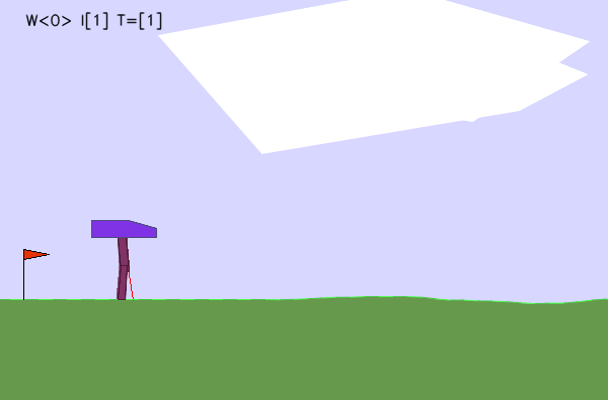

In [12]:
# save the environment video
gif_path = './img/BipedalWalker-v3-w0-e0.gif'

# Embed the video
video = open(gif_path, 'rb').read()
b64_video = base64.b64encode(video)
video_tag = '<img src="data:image/gif;base64,{0}">'.format(b64_video.decode())

display(HTML(video_tag))

In [13]:
env = environment.Environment(0, None, ENV_NAME, True)
print('State Shape:', env.state_size)
print('Number of actions:',  env.action_size)

State Shape: 24
Number of actions: 4


#### States
|Num|Observation|Min|Max|Mean
|---|---|---|---|---|
|0|hull_angle|0|2*pi|0.5
|1|hull_angularVelocity|-inf|+inf|-
|2|vel_x|-1|+1|-
|3|vel_y|-1|+1|-
|4|hip_joint_1_angle|-inf|+inf|-
|5|hip_joint_1_speed|-inf|+inf|-
|6|knee_joint_1_angle|-inf|+inf|-
|7|knee_joint_1_speed|-inf|+inf|-
|8|leg_1_ground_contact_flag|0|1|-
|9|hip_joint_2_angle|-inf|+inf|-
|10|hip_joint_2_speed|-inf|+inf|-
|11|knee_joint_2_angle|-inf|+inf|-
|12|knee_joint_2_speed|-inf|+inf|-
|13|leg_2_ground_contact_flag|0	1|-
|14-23|10 lidar readings|-inf|+inf|-

#### Actions
|Num|Name|Min|Max|
|---|---|---|---|
|0|Hip_1 (Torque / Velocity)|-1|+1|
|1|Knee_1 (Torque / Velocity)|-1|+1|
|2|Hip_2 (Torque / Velocity)|-1|+1|
|3|Knee_2 (Torque / Velocity)|-1|+1|

-----

## Replay Buffer

In [14]:
# Replay buffer 
class ReplayBuffer:
    def __init__(self, state_dim, action_dim, max_size = MEMORY_SIZE):
        self.state_memory = np.zeros((max_size, state_dim), dtype=np.float32)
        self.new_state_memory = np.zeros((max_size, state_dim), dtype=np.float32)
        self.action_memory = np.zeros((max_size, action_dim), dtype=np.float32)
        self.reward_memory = np.zeros(max_size, dtype=np.float32)
        self.terminal_memory = np.zeros(max_size, dtype=np.bool_)

        self.max_size = max_size
        self.ptr = 0

    def store_transition(self, state, action, reward, next_state, done):
        index = self.ptr % self.max_size

        self.state_memory[index] = state
        self.new_state_memory[index] = next_state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done

        self.ptr += 1

    def sample_buffer(self, batch_size):
        buffer_size = min(self.ptr, self.max_size)
        batch_indices = np.random.choice(buffer_size, batch_size, replace=False)

        states = self.state_memory[batch_indices]
        next_states = self.new_state_memory[batch_indices]
        actions = self.action_memory[batch_indices]
        rewards = self.reward_memory[batch_indices]
        dones = self.terminal_memory[batch_indices]

        return states, actions, rewards, next_states, dones

In [15]:
class DDPGAgent:
    def __init__(
        self,
        state_dim,
        action_dim,
        max_action,
        lr_critic = ALPHA_C,
        lr_actor = ALPHA_A,
        gamma = GAMMA,
        tau = TAU
    ):
        # Initialize dimensions
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.max_action = max_action

        # Replay buffer
        self.replay_buffer = ReplayBuffer(state_dim, action_dim)
        self.batch_size = MINIBATCH_SIZE

        # Discount factor
        self.gamma = gamma

        # Target update rate
        self.tau = tau

        # Actor Model
        self.actor_model = self.build_actor_model()
        self.actor_optimizer = Adam(learning_rate=lr_actor)

        # Critic Model
        self.critic_model = self.build_critic_model()
        self.critic_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_critic)

        # Target actor Model
        self.target_actor = self.build_actor_model()
        self.target_actor.set_weights(self.actor_model.get_weights())

        # Target critic Model
        self.target_critic = self.build_critic_model()
        self.target_critic.set_weights(self.critic_model.get_weights())

    def build_actor_model(self):
        model = tf.keras.Sequential([
            Input((self.state_dim,)),                           # 24
            Dense(400, activation='relu'),                      # 512
            Dense(300, activation='relu'),                      # 256
            Dense(self.action_dim, activation='tanh')           # 4
        ])
        return model

    def build_critic_model(self):
        # State input
        state_input = Input((self.state_dim,))                  # 24
        state_out = Dense(16, activation='relu')(state_input)   # 32
        state_out = Dense(32, activation='relu')(state_out)     # 48

        # Action input
        action_input = Input((self.action_dim,))                # 4
        action_out = Dense(32, activation='relu')(action_input) # 48

        # Both are passed through seperate layer before concatenating
        concat = Concatenate()([state_out, action_out])         # 48 * 2

        out = Dense(400, activation='relu')(concat)             # 512
        out = Dense(300, activation='relu')(out)                # 256
        outputs = Dense(1)(out)                                 # 1

        # Outputs single value for give state-action
        model = tf.keras.Model([state_input, action_input], outputs)

        return model
    
    def update(self, state_batch, action_batch, reward_batch, next_state_batch, done_batch):
        with tf.GradientTape() as tape:
            target_actions = self.target_actor(next_state_batch, training=True)
            y = reward_batch + (1-done_batch) * (self.gamma * self.target_critic([next_state_batch, target_actions], training=True))
            critic_value = self.critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, self.critic_model.trainable_variables)
        self.critic_optimizer.apply_gradients(zip(critic_grad, self.critic_model.trainable_variables))

        with tf.GradientTape() as tape:
            actions = self.actor_model(state_batch, training=True)
            critic_value = self.critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, self.actor_model.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_grad, self.actor_model.trainable_variables))

        
    def update_target(self, model, target_model):
        model_weights = model.get_weights()
        target_weights = target_model.get_weights()
        for i in range(len(model_weights)):
            target_weights[i] = self.tau * model_weights[i] + (1 - self.tau) * target_weights[i]

        target_model.set_weights(target_weights)

    def get_action(self, state):
        return self.actor_model.predict(state, verbose=0)

    def learn(self):
        if self.replay_buffer.ptr < self.batch_size:
            return

        state_batch, action_batch, reward_batch, next_state_batch, done_batch = self.replay_buffer.sample_buffer(self.batch_size)

        self.update(state_batch, action_batch, reward_batch, next_state_batch, done_batch)

        self.update_target(self.actor_model, self.target_actor)
        self.update_target(self.critic_model, self.target_critic)

    def store_transition(self, state, action, reward, next_state, done):
        self.replay_buffer.store_transition(state, action, reward, next_state, done)


In [16]:
# Initialize gym environment and the agent
# env = gym.make('BipedalWalker-v3')
# agent = DDPGAgent(env.observation_space.shape[0], env.action_space.shape[0], env.action_space.high[0])

In [17]:
def multi_train():
    # Workers storages
    works, parent_conns, child_conns = [], [], []
    
    episode = 0
    max_episode = 1000
    
    # init worker one by one
    for idx in range(NUM_WORKER):
        parent_conn, child_conn = Pipe()
        work = environment.Environment(idx, child_conn, ENV_NAME, episode, True, 250)
        work.start()
        # store worker and worker's relation
        works.append(work)
        parent_conns.append(parent_conn)
        child_conns.append(child_conn)
        episode += 1
    
    # init variables storages for each workers
    next_states =   [None for _ in range(NUM_WORKER)]
    actions =       [[] for _ in range(NUM_WORKER)]
    rewards =       [[] for _ in range(NUM_WORKER)]
    dones =         [[] for _ in range(NUM_WORKER)]
    score =         [0 for _ in range(NUM_WORKER)]
    worker_list =   [[None, None, None, None, None] for _ in range(NUM_WORKER) ] # array of all workers infos (index, local_iter, global_iter, timestep, message
    
    state = [None for _ in range(NUM_WORKER)]
    
    agent = DDPGAgent(works[0].state_size, works[0].action_size, works[0].env.action_space.high[0])
    
    
    # used to initialise empty state array
    for worker_id, parent_conn in enumerate(parent_conns):
        # initial state
        _, msg_info = parent_conn.recv()
        state[worker_id] = msg_info
    
    # 1 - loop
    while episode < max_episode:
        current_iter_done = False
        for worker_id, parent_conn in enumerate(parent_conns):
            # function to override printlines from previous loop iteration 
            clear_output(wait=True)
            # Init message box
            msg_title, msg_info = "", None

            # Check if we are waiting a message
            if parent_conn.poll():
                msg_title, msg_info = parent_conn.recv()

            if msg_title == "1 - INITIAL_STATE":
                state[worker_id] = msg_info
            elif msg_title ==  "3 - LOOP_INFOS":
                # Recieve a worker loop info
                worker_idx, iteration, current_episode, timestep = msg_info
                worker_list[worker_idx] = [worker_idx, iteration, current_episode, timestep, ""]
                print_workers(worker_list)

                # SELECTING AN ACTION
                action = agent.get_action(np.reshape(state[worker_id], [1, agent.state_dim]))
                action = np.squeeze(action, axis=0)
                action = np.clip(action, works[worker_id].env.action_space.low, works[worker_id].env.action_space.high)
                # send the selected action
                parent_conn.send(action)
                # saving the current action
                actions[worker_id] = np.reshape(action, [1, agent.action_dim])
            elif msg_title == "5 - ENV_STEP":
                # in this exemple only done variable is important
                next_state, reward, done, _ = msg_info
                
                # Store transition for training
                agent.store_transition(state[worker_id], actions[worker_id], reward, next_state, done)
                
                # Train the agent with the experience
                agent.learn()

                # storing all infos
                next_states[worker_id] = next_state
                rewards[worker_id].append(reward)
                dones[worker_id] = done
                state[worker_id] = next_state
                score[worker_id] += reward
            elif msg_title == "6 - SAVING_GAME" or msg_title == "7 - GAME_SAVED":
                worker_idx = 0 # because we have only one worker here
                worker_idx, iteration, current_episode, timestep, msg = worker_list[worker_idx]
                worker_list[worker_idx] = [worker_idx, iteration, current_episode, timestep, msg_info]
                print_workers(worker_list)
            elif msg_title == "8 - ITERATION_DONE":
                episode += 1
                works[worker_id].set_current_episode(episode)
                if episode < max_episode - NUM_WORKER:
                    current_iter_done = True

            # if we want to do more than one iteration loop
            if current_iter_done:
                parent_conn.send('continue')

    # RECEIVING ENV STATE
    for worker_id, parent_conn in enumerate(parent_conns):
        parent_conn.send('terminate')  # Send termination message
        works[worker_id].join()
    return agent

In [ ]:
trained_agent = multi_train()

Worker=<0> Iter=[1] G_Iter=[0] ░░░░░░░░░░ (106/1600)
Worker=<1> Iter=[1] G_Iter=[1] ░░░░░░░░░░ (106/1600)
Worker=<2> Iter=[1] G_Iter=[2] ░░░░░░░░░░ (106/1600)
Worker=<3> Iter=[1] G_Iter=[3] ░░░░░░░░░░ (106/1600)
Worker=<4> Iter=[1] G_Iter=[4] ░░░░░░░░░░ (106/1600)
Worker=<5> Iter=[1] G_Iter=[5] ░░░░░░░░░░ (106/1600)
Worker=<6> Iter=[1] G_Iter=[6] ░░░░░░░░░░ (106/1600)
Worker=<7> Iter=[1] G_Iter=[7] ░░░░░░░░░░ (106/1600)


In [ ]:
assert 'a' == 'b'

In [33]:
# Iterate the game
for episode in range(1000):
    # Reset state in the beginning of each game
    state, _ = env.reset()
    episode_reward = 0

    while True:
        # Decide action
        action = agent.get_action(np.reshape(state, [1, agent.state_dim]))
        action = np.squeeze(action, axis=0)
        action = np.clip(action, env.action_space.low, env.action_space.high)

        # Perform the action and get the next_state, reward, and done information
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward

        # Store transition for training
        agent.store_transition(state, action, reward, next_state, done)

        # Train the agent with the experience
        agent.learn()

        state = next_state
        if done:
            break

    print(f"Episode: {episode}, Reward: {episode_reward}")

Episode: 0, Reward: -95.32165568975405
Episode: 1, Reward: -102.5214457341116
Episode: 2, Reward: -107.08473124094245
Episode: 3, Reward: -94.4190855270146
Episode: 4, Reward: -96.12310910019092
Episode: 5, Reward: -97.93696606892999
Episode: 6, Reward: -99.62389164021984
Episode: 7, Reward: -97.5126172360039
Episode: 8, Reward: -98.40145418975005
Episode: 9, Reward: -98.24994274308905
Episode: 10, Reward: -100.84475755161543
Episode: 11, Reward: -101.15392173473226
Episode: 12, Reward: -98.59399645889737
Episode: 13, Reward: -100.10556482003443
Episode: 14, Reward: -97.08613151621695
Episode: 15, Reward: -99.99123464874333
Episode: 16, Reward: -96.96593572271817
Episode: 17, Reward: -97.46565253996663
Episode: 18, Reward: -97.37198001248079
Episode: 19, Reward: -96.84573444296048
Episode: 20, Reward: -98.05311528157505
Episode: 21, Reward: -115.72129759502349


KeyboardInterrupt: 

In [ ]:
# Workers storages
works, parent_conns, child_conns = [], [], []

# init worker one by one
for idx in range(NUM_WORKER):
    parent_conn, child_conn = Pipe()
    work = environment.Environment(idx, child_conn, ENV_NAME, True)
    work.start()
    # store worker and worker's relation
    works.append(work)
    parent_conns.append(parent_conn)
    child_conns.append(child_conn)

# init variables storages for each workers
states =        [[] for _ in range(NUM_WORKER)]
next_states =   [[] for _ in range(NUM_WORKER)]
actions =       [[] for _ in range(NUM_WORKER)]
rewards =       [[] for _ in range(NUM_WORKER)]
dones =         [[] for _ in range(NUM_WORKER)]
score =         [0 for _ in range(NUM_WORKER)]

state = [None for _ in range(NUM_WORKER)]

for worker_id, parent_conn in enumerate(parent_conns):
    # initial state
    state[worker_id] = parent_conn.recv()

episode = 0
while episode < EPISODES:
    # SELECTING AN ACTION
    action = agent.get_action(np.reshape(state, [NUM_WORKER, agent.state_dim]))
    action = np.squeeze(action, axis=1)
    action = np.clip(action, env.action_space.low, env.action_space.high)
    
    # SENDING THE ACTION
    for worker_id, parent_conn in enumerate(parent_conns):
        # sending the action to the env
        parent_conn.send(action[worker_id])
        # saving the current action
        actions[worker_id].append(action[worker_id])
    
    # RECEIVING ENV STATE
    for worker_id, parent_conn in enumerate(parent_conns):
        # waiting env next_state reward done
        next_state, reward, done, _ = parent_conn.recv()
        
        # Store transition for training
        agent.store_transition(state[worker_id], actions[worker_id], reward, next_state, done)

        # Train the agent with the experience
        agent.learn()

        # storing all infos
        states[worker_id].append(state[worker_id])
        next_states[worker_id].append(next_state)
        rewards[worker_id].append(reward)
        dones[worker_id].append(done)
        state[worker_id] = next_state
        score[worker_id] += reward
        
        if done:
            episode += 1

# RECEIVING ENV STATE
for worker_id, parent_conn in enumerate(parent_conns):
    parent_conn.send('terminate')  # Send termination message
    works[worker_id].join()

In [12]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            tf.convert_to_tensor(states, dtype=tf.float32),
            tf.convert_to_tensor(actions, dtype=tf.float32),
            tf.convert_to_tensor(rewards, dtype=tf.float32),
            tf.convert_to_tensor(next_states, dtype=tf.float32),
            tf.convert_to_tensor(dones, dtype=tf.float32)
        )

    def __len__(self):
        return len(self.buffer)

In [108]:
class DDPGAgent:
    def __init__(self, env):
        self.env = env
        self.obs_dim = env.observation_space.shape[0]
        self.act_dim = env.action_space.shape[0]
        self.act_high = env.action_space.high[0]

        self.actor_model = self.build_actor_model()
        self.critic_model = self.build_critic_model()

        self.target_actor = self.build_actor_model()
        self.target_critic = self.build_critic_model()

        self.target_actor.set_weights(self.actor_model.get_weights())
        self.target_critic.set_weights(self.critic_model.get_weights())

        self.critic_optimizer = Adam(learning_rate=0.002)
        self.actor_optimizer = Adam(learning_rate=0.001)

    def build_actor_model(self):
        model = tf.keras.Sequential([
            Dense(64, activation="relu", input_shape=(self.obs_dim,)),
            Dense(48, activation="relu"),
            Dense(self.act_dim, activation="tanh")
        ])
        return model

    def build_critic_model(self):
        obs_input = Input(shape=(self.obs_dim,))
        act_input = Input(shape=(self.act_dim,))
        obs_branch = Dense(64, activation="relu")(obs_input) # 400
        act_branch = Dense(48, activation="relu")(act_input) # 300
        concat = Concatenate()([obs_branch, act_branch])
        concat = Dense(48, activation="relu")(concat)
        output = Dense(1)(concat)
        model = tf.keras.Model(inputs=[obs_input, act_input], outputs=output)
        return model

    def get_action(self, state):
        state = np.reshape(state, (1, self.obs_dim))  # Reshape the state variable
        state = tf.convert_to_tensor(state, dtype=tf.float32)
        actions = self.actor_model(state)
        actions += tf.random.normal(shape=[self.act_dim], mean=0.0, stddev=0.1)
        actions = tf.clip_by_value(actions, -self.act_high, self.act_high)
        return actions[0]

    def update_target_networks(self, tau=0.005):
        weights = []
        targets = self.target_actor.weights
        for i, weight in enumerate(self.actor_model.weights):
            weights.append(weight * tau + targets[i] * (1 - tau))
        self.target_actor.set_weights(weights)

        weights = []
        targets = self.target_critic.weights
        for i, weight in enumerate(self.critic_model.weights):
            weights.append(weight * tau + targets[i] * (1 - tau))
        self.target_critic.set_weights(weights)

    def train(self, replay_buffer, batch_size=64, gamma=0.99):
        states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

        with tf.GradientTape() as tape:
            target_actions = self.target_actor(next_states, training=True)
            q_values = self.target_critic([next_states, target_actions], training=True)
            y = rewards + (1 - dones) * gamma * q_values
            critic_value = self.critic_model([states, actions], training=True)
            critic_loss = tf.reduce_mean(tf.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, self.critic_model.trainable_variables)
        self.critic_optimizer.apply_gradients(zip(critic_grad, self.critic_model.trainable_variables))

        with tf.GradientTape() as tape:
            actions = self.actor_model(states, training=True)
            critic_value = self.critic_model([states, actions], training=True)
            actor_loss = -tf.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, self.actor_model.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_grad, self.actor_model.trainable_variables))

        self.update_target_networks()

In [109]:
def train_agent(env, agent, replay_buffer, episodes=1000, batch_size=64):
    start = time.time()
    
    total_reward_history = []

    num_p_av = 100    # number of total points to use for averaging
    
    for episode in range(episodes):
        start_episode = time.time()
        state, _ = env.reset()
        total_reward = 0
        done = False
        step = 0

        while not done:
            action = agent.get_action(state)
            # Take action A and receive reward R and the next state S'
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            replay_buffer.push(state, action, reward, next_state, done)

            if len(replay_buffer) > batch_size:
                agent.train(replay_buffer, batch_size)
                # selected_columns = tf.gather(replay_buffer.sample(batch_size)[0][:, :13], indices=[0, 4, 6, 9, 11], axis=1)
                # max = tf.math.reduce_max(selected_columns, axis=0)
                # min = tf.math.reduce_min(selected_columns, axis=0)
                # variances = tf.reduce_mean(tf.math.reduce_variance(selected_columns, axis=0))
                # variances = tf.reduce_mean(max - min)
                # variances
                # print(f"\rVariance {variances}")
            
            state = next_state
            total_reward += reward
            step += 1

        # print(f"Episode: {episode + 1}, Reward: {total_reward}")
        
        total_reward_history.append(total_reward)
        av_latest_rewards = np.mean(total_reward_history[-num_p_av:])

        tot_time_episode = time.time() - start_episode
        print(f"\rEpisode {episode+1} | Total point average of the last {num_p_av} episodes: {av_latest_rewards:.2f} | Runtime: {tot_time_episode:.2f} s ({(tot_time_episode/60):.2f} min) | step: {step}    ", end="")

        if (episode+1) % num_p_av == 0:
            print(f"\rEpisode {episode+1} | Total point average of the last {num_p_av} episodes: {av_latest_rewards:.2f}")

        # We will consider that the environment is solved if we get an
        # average of 300 points in the last 100 episodes.
        if av_latest_rewards >= env.spec.reward_threshold:
            print(f"\n\nEnvironment solved in {episode+1} episodes!")
            # agent.q_network.save(SAVE_PATH)
            break
    tot_time = time.time() - start
    print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")
    return total_reward_history

In [73]:
replay_buffer.sample(64)[0][0, :]

<tf.Tensor: shape=(24,), dtype=float32, numpy=
array([ 3.1643295e-01, -2.6379054e-02,  1.0833551e-01, -2.2666091e-02,
       -7.4247307e-01,  9.6336797e-02, -3.4849977e-01,  2.5374398e-01,
        0.0000000e+00, -8.1697446e-01,  1.9371510e-07, -6.2141848e-01,
        4.2057037e-04,  1.0000000e+00,  2.5952727e-01,  2.6247460e-01,
        2.7166060e-01,  2.8822047e-01,  3.1445059e-01,  3.5469621e-01,
        4.1750821e-01,  5.2158839e-01,  7.1621835e-01,  1.0000000e+00],
      dtype=float32)>

In [103]:
replay_buffer.sample(64)[0][0, :13]

<tf.Tensor: shape=(13,), dtype=float32, numpy=
array([ 0.17616658,  0.0057343 ,  0.06247948, -0.01943035,  1.1014044 ,
       -0.05850724, -0.62276626,  0.        ,  0.        ,  0.11824071,
       -0.12758124, -0.60787416,  0.00114959], dtype=float32)>

In [104]:
replay_buffer.sample(64)[1][0, :13]

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([-0.02164194,  0.05850307,  0.04477605, -0.20628145], dtype=float32)>

In [50]:
replay_buffer.sample(64)[0][:, :13].shape

TensorShape([64, 13])

In [88]:
tf.math.reduce_variance(replay_buffer.sample(64)[0][:, :13], axis=0)

<tf.Tensor: shape=(13,), dtype=float32, numpy=
array([0.12697373, 0.00087196, 0.00382895, 0.00288065, 0.34671134,
       0.13513193, 0.04584408, 0.10971437, 0.24902344, 0.40391836,
       0.1676    , 0.03657784, 0.1383184 ], dtype=float32)>

In [92]:
selected_columns = tf.gather(replay_buffer.sample(64)[0][:, :13], indices=[0, 4, 6, 9, 11], axis=1)
selected_columns.shape

TensorShape([64, 5])

In [89]:

variances = tf.reduce_mean(tf.math.reduce_variance(selected_columns, axis=0))
variances

<tf.Tensor: shape=(), dtype=float32, numpy=0.2122999>

In [110]:
env = gym.make('BipedalWalker-v3', render_mode="rgb_array")

In [111]:
replay_buffer = ReplayBuffer(capacity=1000000)

In [112]:
agent = DDPGAgent(env)

In [113]:
trh = train_agent(env, agent, replay_buffer)

Episode 100 | Total point average of the last 100 episodes: -111.69 | Runtime: 5.67 s (0.09 min) | step: 77       
Episode 113 | Total point average of the last 100 episodes: -113.07 | Runtime: 6.40 s (0.11 min) | step: 76    

KeyboardInterrupt: 

In [ ]:
assert 'a' == 'b'

# OLD
-----

### ReplayBuffer Class

In [ ]:
class ReplayBuffer(object):

    def __init__(self, buffer_size, random_seed=123):
        """
        The right side of the deque contains the most recent experiences 
        """
        self.buffer_size = buffer_size
        self.count = 0
        self.buffer = deque()
        random.seed(random_seed)

    def add(self, s, a, r, t, s2):
        experience = (s, a, r, t, s2)
        if self.count < self.buffer_size: 
            self.buffer.append(experience)
            self.count += 1
        else:
            self.buffer.popleft()
            self.buffer.append(experience)

    def size(self):
        return self.count

    def sample_batch(self, batch_size):
        batch = []

        if self.count < batch_size:
            batch = random.sample(self.buffer, self.count)
        else:
            batch = random.sample(self.buffer, batch_size)

        s_batch = np.array([_[0] for _ in batch])
        a_batch = np.array([_[1] for _ in batch])
        r_batch = np.array([_[2] for _ in batch])
        t_batch = np.array([_[3] for _ in batch])
        s2_batch = np.array([_[4] for _ in batch])

        return s_batch, a_batch, r_batch, t_batch, s2_batch

    def clear(self):
        self.buffer.clear()
        self.count = 0

### Critic Network
The critic Network take in inputs, the env states and actions to predict a q_value (Q(s,a))

In [ ]:
class Critic(tf.keras.Model):
    def __init__(self):
        super(Critic, self).__init__()
        self.f1 = Dense(HIDDEN_LAYER_SIZE, activation='relu')
        self.d1 = Dropout(0.2) # Add a dropout rate of 0.2
        self.f2 = Dense(HIDDEN_LAYER_SIZE, activation='relu')
        self.d2 = Dropout(0.2) # Add a dropout rate of 0.2
        self.v =  Dense(1, activation=None)

    def call(self, input_state, action):
        x = self.f1(tf.concat([input_state, action], axis=1))
        x = self.d1(x)
        x = self.f2(x)
        x = self.d2(x)
        x = self.v(x)
        return x

### Actor Network
The actor network take in input, the env states to predict actions

In [ ]:
class Actor(tf.keras.Model):
    def __init__(self, no_action):
        super(Actor, self).__init__()    
        self.f1 = Dense(HIDDEN_LAYER_SIZE, activation='relu')
        self.d1 = Dropout(0.2) # Add a dropout rate of 0.2
        self.f2 = Dense(HIDDEN_LAYER_SIZE, activation='relu')
        self.d2 = Dropout(0.2) # Add a dropout rate of 0.2
        self.mu =  Dense(no_action, activation='tanh')

    def call(self, state):
        x = self.f1(state)
        x = self.d1(x)
        x = self.f2(x)
        x = self.d2(x)
        x = self.mu(x) 
        return x

### Agent

In [ ]:
class Agent():
    def __init__(self, n_action= len(env.action_space.high)):
        self.actor_main = Actor(n_action)
        self.actor_target = Actor(n_action)
        self.critic_main = Critic()
        self.critic_main2 = Critic()
        self.critic_target = Critic()
        self.critic_target2 = Critic()
        self.batch_size = MINIBATCH_SIZE
        self.n_actions = n_action
        self.a_opt = Adam(ALPHA)
        self.c_opt1 = Adam(0.002)
        self.c_opt2 = Adam(0.002)
        self.memory = ReplayBuffer(MEMORY_SIZE)
        self.trainstep = 0
        # self.replace = 5
        self.gamma = GAMMA
        self.min_action = env.action_space.low[0]
        self.max_action = env.action_space.high[0]
        self.warmup = 200
        self.actor_update_steps = NUM_STEPS_FOR_UPDATE
        self.tau = TAU
        self.actor_target.compile(optimizer=self.a_opt)
        self.critic_target.compile(optimizer=self.c_opt1)
        self.critic_target2.compile(optimizer=self.c_opt2)

    def act(self, state, evaluate=False):
        if self.trainstep > self.warmup:
          evaluate = True
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        actions = self.actor_main(state)
        if not evaluate:
            actions += tf.random.normal(shape=[self.n_actions], mean=0.0, stddev=0.1)

        actions = self.max_action * (tf.clip_by_value(actions, self.min_action, self.max_action))
        return actions[0]
    
    def update_target(self, tau=None):
        if tau is None:
            tau = self.tau

        weights1 = []
        targets1 = self.actor_target.weights
        for i, weight in enumerate(self.actor_main.weights):
            weights1.append(weight * tau + targets1[i]*(1-tau))
        self.actor_target.set_weights(weights1)

        weights2 = []
        targets2 = self.critic_target.weights
        for i, weight in enumerate(self.critic_main.weights):
            weights2.append(weight * tau + targets2[i]*(1-tau))
        self.critic_target.set_weights(weights2)
        
    def train(self):
        if self.memory.size() < self.batch_size:
            return 
        states, actions, rewards, dones, next_states = self.memory.sample_batch(self.batch_size)
  
        states = tf.convert_to_tensor(states, dtype= tf.float32)
        next_states = tf.convert_to_tensor(next_states, dtype= tf.float32)
        rewards = tf.convert_to_tensor(rewards, dtype= tf.float32)
        actions = tf.convert_to_tensor(actions, dtype= tf.float32)
        # dones = tf.convert_to_tensor(dones, dtype= tf.bool) # = 1 - dones

        with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
            
            target_actions = self.actor_target(next_states)
            target_actions += tf.clip_by_value(tf.random.normal(shape=[*np.shape(target_actions)], mean=0.0, stddev=0.2), -0.5, 0.5)
            target_actions = self.max_action * (tf.clip_by_value(target_actions, self.min_action, self.max_action))
            
            target_next_state_values = tf.squeeze(self.critic_target(next_states, target_actions), 1)
            target_next_state_values2 = tf.squeeze(self.critic_target2(next_states, target_actions), 1)

            critic_value = tf.squeeze(self.critic_main(states, actions), 1)
            critic_value2 = tf.squeeze(self.critic_main2(states, actions), 1)

            # we alaways get the minimum in order to not surestimate the value
            next_state_target_value = tf.math.minimum(target_next_state_values, target_next_state_values2)

            target_values = rewards + (self.gamma * target_next_state_values * dones)
            critic_loss1 = tf.keras.losses.MSE(target_values, critic_value)
            critic_loss2 = tf.keras.losses.MSE(target_values, critic_value2)

        grads1 = tape1.gradient(critic_loss1, self.critic_main.trainable_variables)
        grads2 = tape2.gradient(critic_loss2, self.critic_main2.trainable_variables)
        self.c_opt1.apply_gradients(zip(grads1, self.critic_main.trainable_variables))
        self.c_opt2.apply_gradients(zip(grads2, self.critic_main2.trainable_variables))

        self.trainstep +=1

        if self.trainstep % self.actor_update_steps == 0:
            with tf.GradientTape() as tape3:
                new_policy_actions = self.actor_main(states)
                actor_loss = -self.critic_main(states, new_policy_actions)
                actor_loss = tf.math.reduce_mean(actor_loss)

            grads3 = tape3.gradient(actor_loss, self.actor_main.trainable_variables)
            self.a_opt.apply_gradients(zip(grads3, self.actor_main.trainable_variables))
      
        self.update_target()

        
    def savexp(self, state, next_state, action, done, reward):
        self.memory.add(state, action, reward, done, next_state)

In [ ]:
with tf.device('/device:CPU:0'):
    start = time.time()

    # Create Agent
    tf.random.set_seed(336699)
    agent = Agent(env.action_space.shape[0])

    episods = 500
    max_num_timesteps = 1600

    total_point_history = []

    num_p_av = 100    # number of total points to use for averaging
  
    for i in range(episods):
        # Reset the environment to the initial state and get the initial state
        state, _ = env.reset()
        total_points = 0
    
        for t in range(max_num_timesteps):
            # From the current state S choose an action A
            action = agent.act(state)
            # Take action A and receive reward R and the next state S'
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            # Store experience tuple (S,S',A,T,R) in the memory buffer.
            agent.savexp(state, next_state, action, done, reward)
            # Train models
            agent.train()

            # Update total reward and current state
            state = next_state.copy()
            total_points += reward

            if done:
                break
      
        total_point_history.append(total_points)
        av_latest_points = np.mean(total_point_history[-num_p_av:])

        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

        if (i+1) % num_p_av == 0:
            print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

        # We will consider that the environment is solved if we get an
        # average of 300 points in the last 100 episodes.
        if av_latest_points >= env.spec.reward_threshold:
            print(f"\n\nEnvironment solved in {i+1} episodes!")
            # agent.q_network.save(SAVE_PATH)
            break
    tot_time = time.time() - start
    print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

### Plot utils

In [26]:
def update_plot(frame_number, state, num_iteration):
    action = agent.get_action(state)
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    frame = env.render()

    # converting state to plot in order to stylize it
    fig = Figure()
    canvas = FigureCanvas(fig)
    ax = fig.add_subplot(1,1,1)
    ax.imshow(frame)
    ax.axis('off')
    ax.set_title(f"Timestep=({frame_number}) iter=({num_iteration})")
    canvas.draw()

    # reconverting plot to state
    size = fig.get_size_inches() * fig.dpi
    image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(int(size[1]), int(size[0]), 3)

    if done:
        state, _ = env.reset()
        num_iteration -= 1
        time.sleep(0.5)
        frame_number = 0
    else:
        frame_number += 1
    return image, frame_number, state, num_iteration

In [105]:
def save(num_iteration = 5):
    """Saves an animated GIF of the agent's performance."""
    state, _ = env.reset()
    frame = env.render()
    images = []
    frame_number = 0
    while num_iteration > 0:
        print(f"{(5 - num_iteration)+1}/{5}", end="\r")
        frame, frame_number, state, num_iteration = update_plot(frame_number, state, num_iteration)
        images.append(Image.fromarray(frame))
    print("\nSaving..............", end="\r")            
    images[0].save('img/bipedal_walker2.gif', format='GIF', save_all=True, append_images=images[1:], duration=50, loop=0)
    print("Saved                            ")

In [ ]:
def plot_history(reward_history, rolling_window=20, lower_limit=None, upper_limit=None, plot_rw=True, plot_rm=True):
    """
    Function to plot reward history and its rolling mean with some optional arguments.

    Args:
        reward_history (list): A list of rewards for each episode.
        rolling_window (int): The number of episodes for computing the rolling mean.
        lower_limit (int): Starting episode index for plotting.
        upper_limit (int): Ending episode index for plotting.
        plot_rw (bool): A flag for plotting raw reward history.
        plot_rm (bool): A flag for plotting rolling mean reward history.

    Returns:
        None
    """
    
    # If lower_limit and upper_limit are not provided, use the whole reward_history
    if lower_limit is None or upper_limit is None:
        rh = reward_history
        xs = [x for x in range(len(reward_history))]
    else:
        rh = reward_history[lower_limit:upper_limit]
        xs = [x for x in range(lower_limit,upper_limit)]
   
    # Create a DataFrame and calculate the rolling mean
    df = pd.DataFrame(rh)
    rollingMean = df.rolling(rolling_window).mean()

    # Plot the results
    plt.figure(figsize=(10,7), facecolor='white')
    
    if plot_rw:
        plt.plot(xs, rh, linewidth=1, color='cyan')
    if plot_rm:
        plt.plot(xs, rollingMean, linewidth=2, color='magenta')

    text_color = 'black'
        
    ax = plt.gca()
    ax.set_facecolor('black')
    plt.grid()

    plt.xlabel('Episode', color=text_color, fontsize=30)
    plt.ylabel('Total Points', color=text_color, fontsize=30)
    yNumFmt = mticker.StrMethodFormatter('{x:,}')
    ax.yaxis.set_major_formatter(yNumFmt)
    ax.tick_params(axis='x', colors=text_color)
    ax.tick_params(axis='y', colors=text_color)
    plt.show()

In [28]:
def embed_gif(filename):
    """Embeds an mp4 file in the notebook."""
    gif = open(filename,'rb').read()
    b64 = base64.b64encode(gif)
    tag = '''<img width="840" height="480"  src="data:img/gif;base64,{0}"/>'''.format(b64.decode())
    return IPython.display.HTML(tag)

In [ ]:
# Plot the point history
plot_history(trh)

In [106]:
save(1)

5/5
Saved                            


In [107]:
filename = "./img/bipedal_walker2.gif"
embed_gif(filename)